In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

In [83]:
# Load dataset
raw = pd.read_csv(
    'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
    index_col='date',
)

raw.tail(5)

,store_nbr,family,sales
date,,,
2017-08-15,9,POULTRY,438.132996
2017-08-15,9,PREPARED FOODS,154.552994
2017-08-15,9,PRODUCE,2419.729004
2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000
2017-08-15,9,SEAFOOD,16.000000


In [5]:
# Dropping store and item columns.
sales = raw[['sales']]

In [7]:
# Converting date to Month period ans sum the number of itesm in each month.
sales = sales.resample('M').sum()

In [8]:
sales.head()

,sales
date,
2013-01-31,10327625.0
2013-02-28,9658960.0
2013-03-31,11428497.0
2013-04-30,10993465.0
2013-05-31,11597704.0


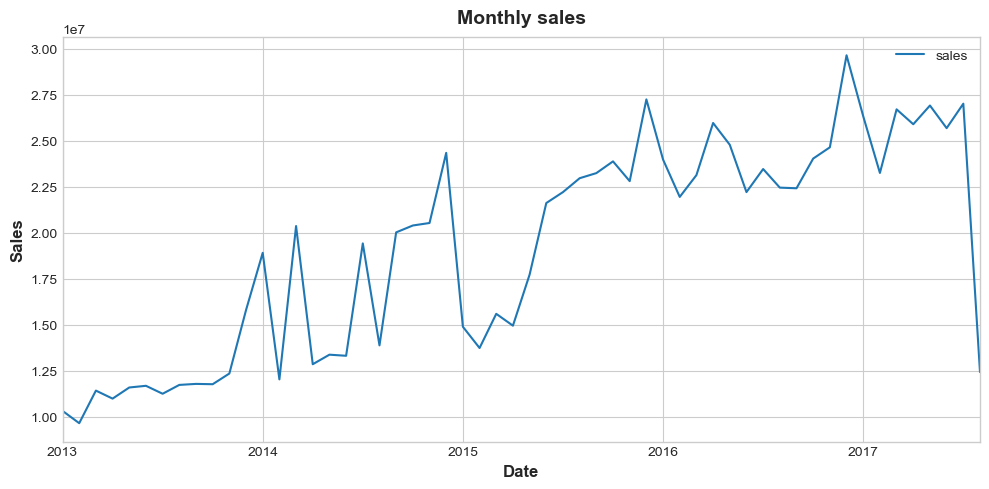

In [84]:
# Plotting th sales
sales.plot(figsize=(10,5))
plt.ylabel('Sales')
plt.xlabel('Date')
plt.title('Monthly sales');

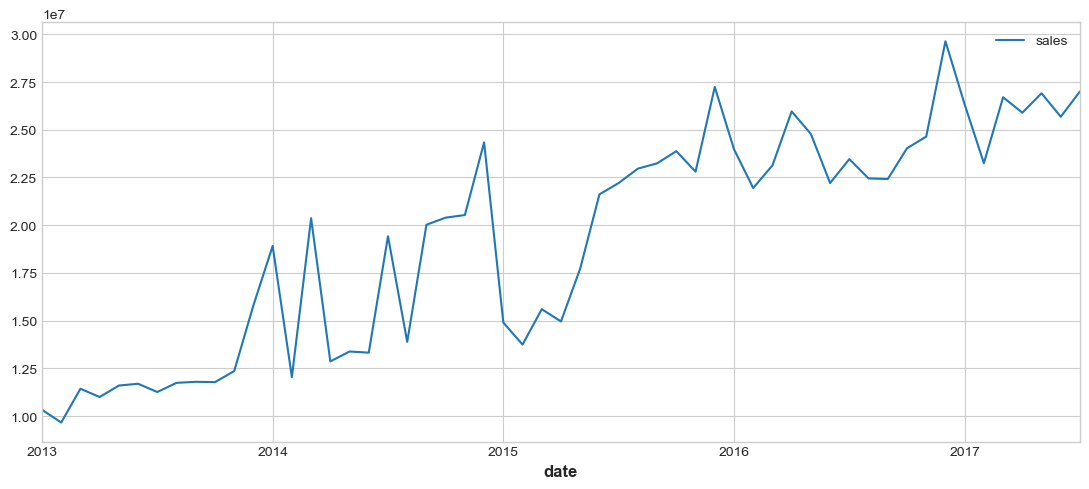

In [10]:
data = sales.drop(sales.tail(1).index)
data.plot();

In [11]:
eda = raw.copy()
eda = eda.reset_index()

In [12]:
sales_by_store = eda.groupby('store_nbr', as_index=False)['sales'].sum().sort_values('sales', ascending=False).head(5)
sales_by_store

,store_nbr,sales
38,44,62087552.0
39,45,54498012.0
41,47,50948312.0
22,3,50481912.0
43,49,43420096.0


In [13]:
top5_storenbr = list(sales_by_store['store_nbr'])
top5_storenbr

['44', '45', '47', '3', '49']

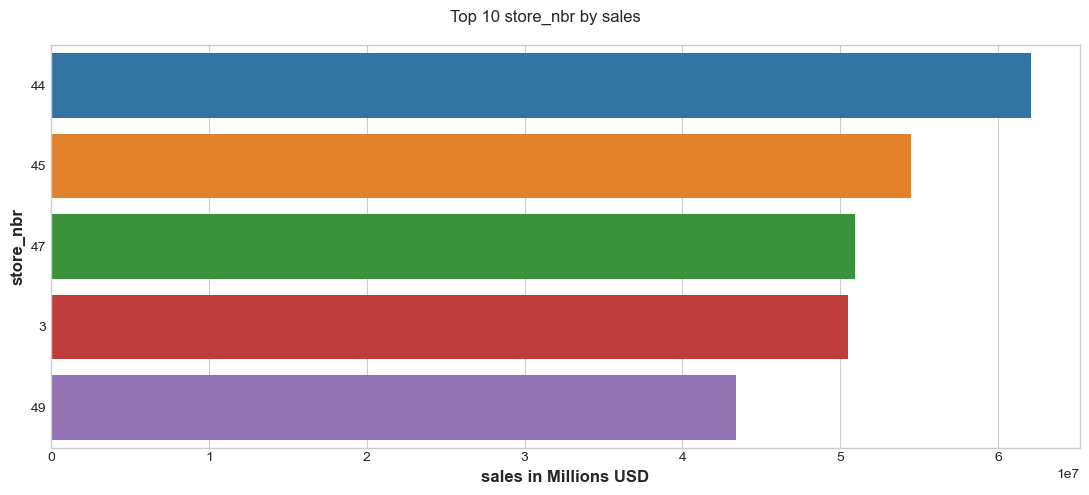

In [14]:
sns.barplot(x='sales', y=top5_storenbr, data=sales_by_store)
plt.suptitle('Top 10 store_nbr by sales')
plt.ylabel('store_nbr')
plt.xlabel('sales in Millions USD');

In [15]:
sales_by_family = eda.groupby('family', as_index=False)['sales'].sum().sort_values('sales', ascending=False).head(5)
sales_by_family

,family,sales
12,GROCERY I,343462720.0
3,BEVERAGES,216954480.0
30,PRODUCE,122704688.0
7,CLEANING,97521288.0
8,DAIRY,64487708.0


In [16]:
top5_families = list(sales_by_family['family'])

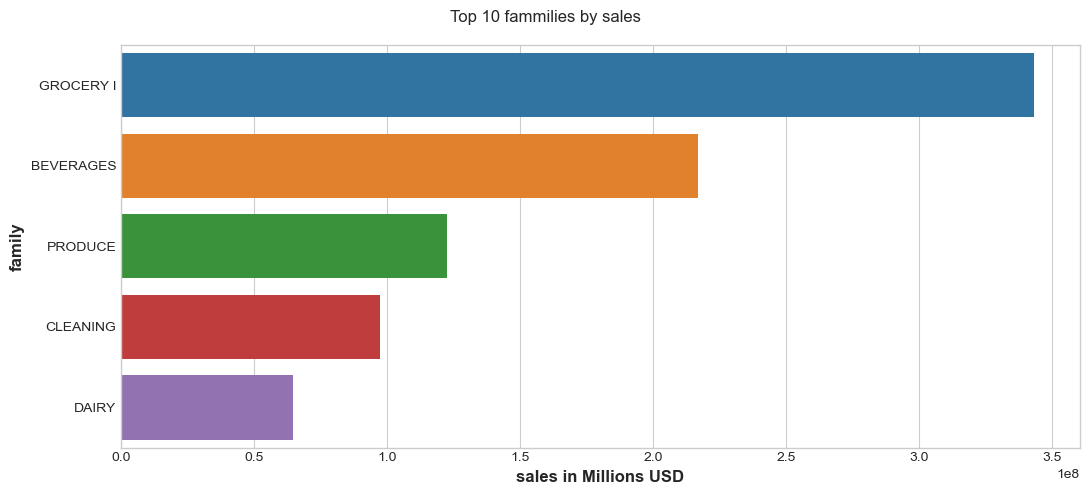

In [17]:
sns.barplot(x='sales', y=top5_families, data=sales_by_family)
plt.suptitle('Top 10 fammilies by sales')
plt.ylabel('family')
plt.xlabel('sales in Millions USD');

In [18]:
sales_store_fam = eda.groupby(['store_nbr', 'family' ], as_index=False).sum().sort_values('sales', ascending=False)
sales_store_fam


,store_nbr,family,sales
1266,44,GROCERY I,16386055.0
1299,45,GROCERY I,16349751.0
1365,47,GROCERY I,15514528.0
1332,46,GROCERY I,14342262.0
1257,44,BEVERAGES,13417859.0
...,...,...,...
679,28,LADIESWEAR,0.0
1637,54,LAWN AND GARDEN,0.0
928,35,BOOKS,0.0
1753,9,BOOKS,0.0


In [19]:
sales_store_fam[sales_store_fam['store_nbr'] == '50'][['family', 'sales']].iloc[0].to_list()[0]

'GROCERY I'

# Linear Regression

### Usando un time step (dummy de la tendencia) como la feature para predecir

In [20]:
train = data.copy()
train['time'] = np.arange(0, len(train))
train.head()

,sales,time
date,,
2013-01-31,10327625.0,0
2013-02-28,9658960.0,1
2013-03-31,11428497.0,2
2013-04-30,10993465.0,3
2013-05-31,11597704.0,4


In [21]:
X = train.loc[:, ['time']]
X.head() # It's a dataframe

,time
date,
2013-01-31,0
2013-02-28,1
2013-03-31,2
2013-04-30,3
2013-05-31,4


In [22]:
y = train.loc[:, 'sales']
y.head() # It's a series

date
2013-01-31    10327625.0
2013-02-28     9658960.0
2013-03-31    11428497.0
2013-04-30    10993465.0
2013-05-31    11597704.0
Freq: M, Name: sales, dtype: float32

In [23]:
# Train the model
model = LinearRegression()
results = model.fit(X, y)

In [24]:
# Make predictions
y_pred = pd.Series(results.predict(X), index=X.index)
y_pred.head()

date
2013-01-31    1.055738e+07
2013-02-28    1.088098e+07
2013-03-31    1.120459e+07
2013-04-30    1.152820e+07
2013-05-31    1.185180e+07
Freq: M, dtype: float64

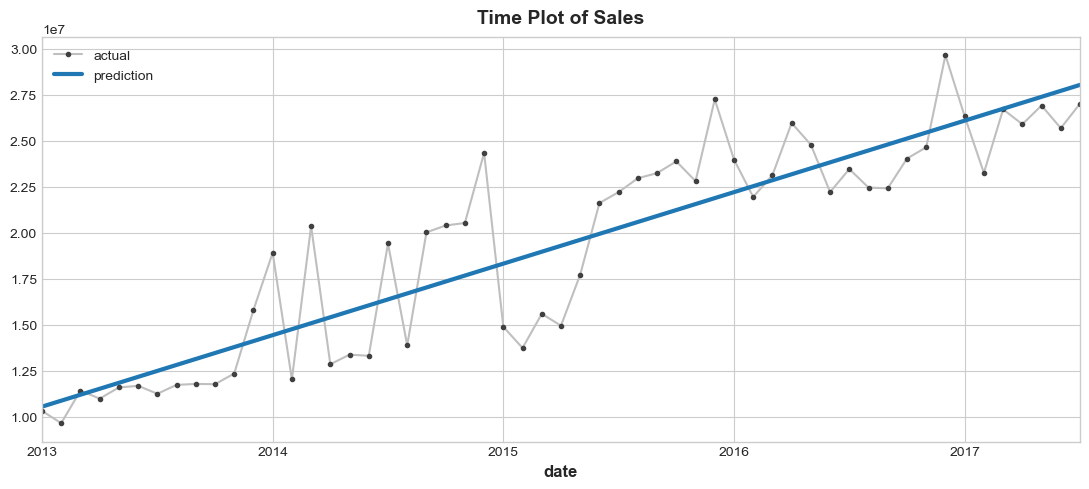

In [25]:
fig, ax = plt.subplots()
ax = y.plot(**plot_params, label='actual')
ax = y_pred.plot(ax=ax, linewidth=3, label='prediction')
ax.set_title('Time Plot of Sales')
plt.legend(loc='best')
plt.show();

#### Aquí podemos ver como se puede generar una regresión solo utilizando un dummy de trend.

### Usando un time step (dummy de la tendencia) como la feature para predecir

In [26]:
train['lag1'] = train['sales'].shift(1)
train.head()

,sales,time,lag1
date,,,
2013-01-31,10327625.0,0,NaN
2013-02-28,9658960.0,1,10327625.0
2013-03-31,11428497.0,2,9658960.0
2013-04-30,10993465.0,3,11428497.0
2013-05-31,11597704.0,4,10993465.0


In [27]:
X = train.loc[:, ['lag1']].dropna()
X.head()

,lag1
date,
2013-02-28,10327625.0
2013-03-31,9658960.0
2013-04-30,11428497.0
2013-05-31,10993465.0
2013-06-30,11597704.0


In [28]:
y = train.loc[:, 'sales'][1:]
y.head()

date
2013-02-28     9658960.0
2013-03-31    11428497.0
2013-04-30    10993465.0
2013-05-31    11597704.0
2013-06-30    11689344.0
Freq: M, Name: sales, dtype: float32

In [29]:
# Train the model
model = LinearRegression()
results = model.fit(X, y)

In [30]:
y_pred = pd.Series(results.predict(X), index=X.index)
y_pred.head()

date
2013-02-28    12089297.0
2013-03-31    11530713.0
2013-04-30    13008935.0
2013-05-31    12645521.0
2013-06-30    13150286.0
Freq: M, dtype: float32

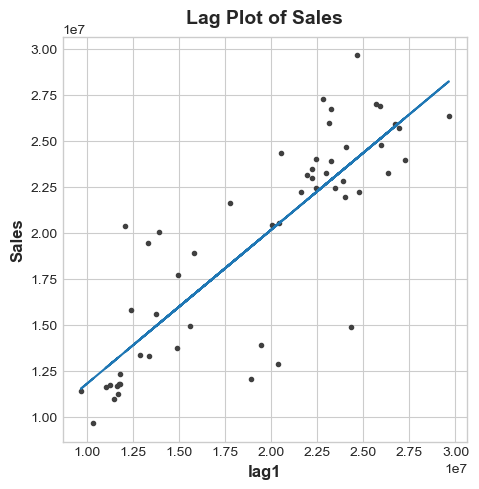

In [31]:
fig, ax = plt.subplots()
ax.plot(X['lag1'], y, '.', color='0.25')
ax.plot(X['lag1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('Sales')
ax.set_xlabel('lag1')
ax.set_title('Lag Plot of Sales');

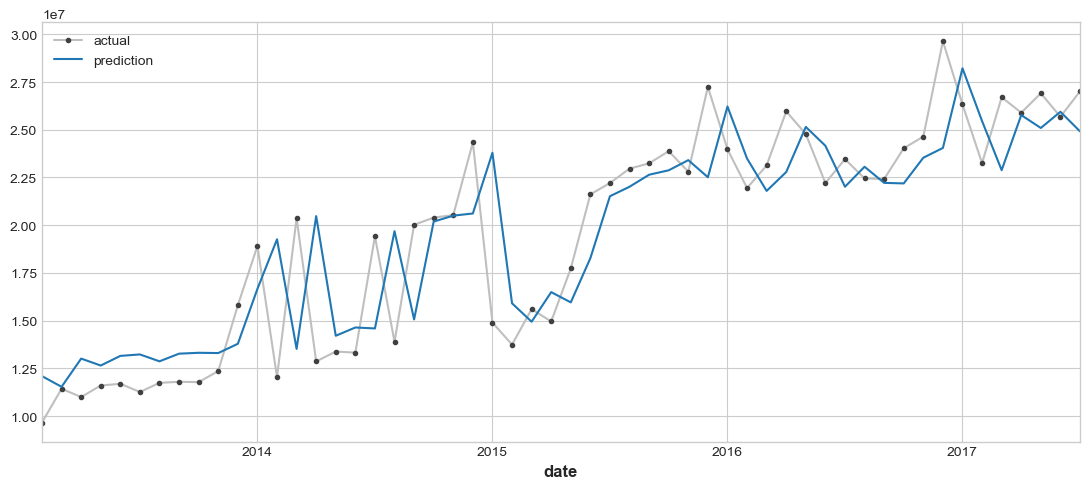

In [32]:
ax = y.plot(**plot_params, label='actual')
ax = y_pred.plot(label='prediction')
plt.legend(loc='best')
plt.show()

# Trend

In [33]:
train = data.copy()

In [34]:
moving_average = train.rolling(
    window=12,
    center=True,
    min_periods=6, # half the size of the window
).mean()

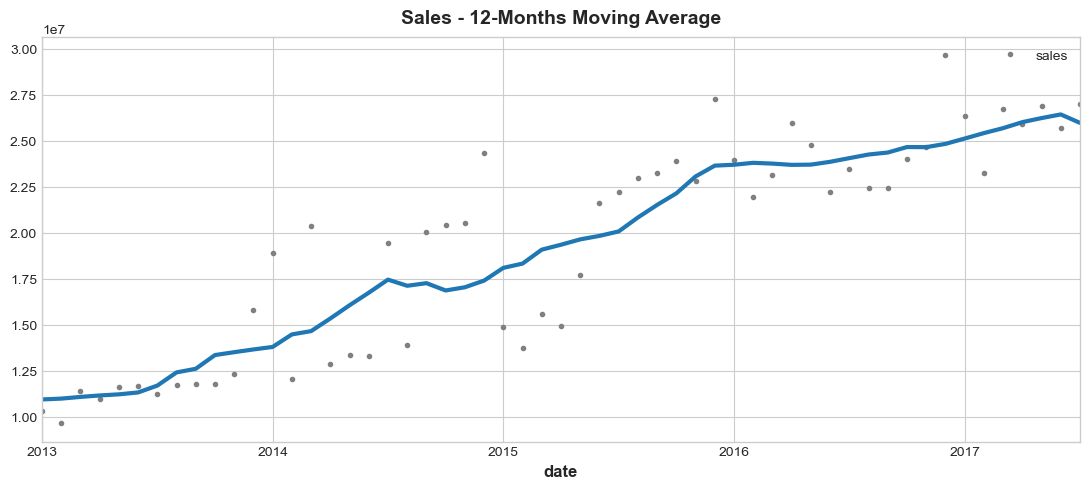

In [35]:
ax = train.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Sales - 12-Months Moving Average", legend=False
);

In [36]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=train.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=2,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)

In [37]:
X = dp.in_sample() # Add trend dummy automatically
X.head()

,const,trend,trend_squared
date,,,
2013-01-31,1.0,1.0,1.0
2013-02-28,1.0,2.0,4.0
2013-03-31,1.0,3.0,9.0
2013-04-30,1.0,4.0,16.0
2013-05-31,1.0,5.0,25.0


In [38]:
y = train['sales']

In [39]:
# The intercept is the same as the `const` feature from DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
results = model.fit(X, y)

y_pred = pd.Series(results.predict(X), index=X.index)

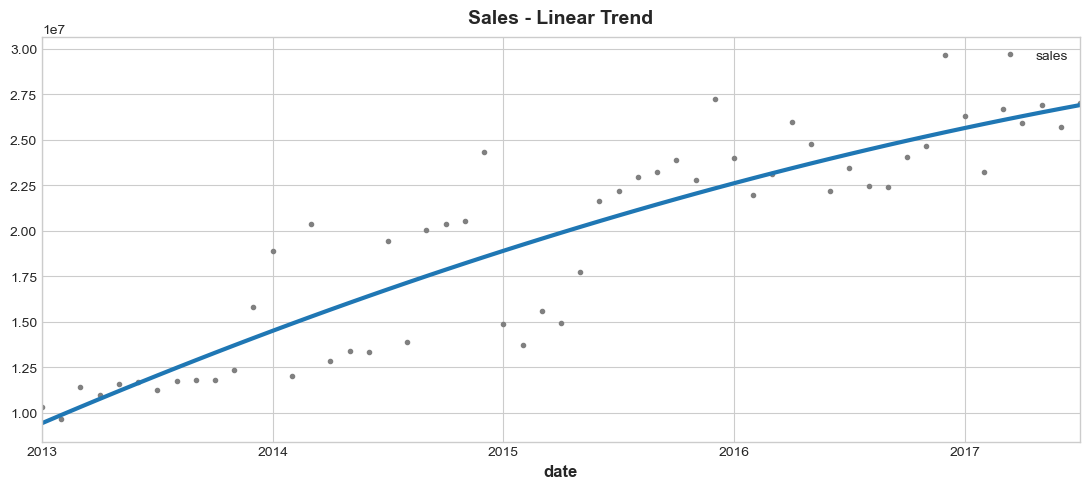

In [40]:
ax = train.plot(style=".", color="0.5", title="Sales - Linear Trend")
pred = y_pred.plot(ax=ax, linewidth=3, label="Trend")

##### The trend discovered by our LinearRegression model is almost identical to the moving average plot, which suggests that a linear trend was the right decision in this case.

In [41]:
X = dp.out_of_sample(steps=12)

y_fore = pd.Series(results.predict(X), index=X.index)

y_fore.head()

2017-08-31    2.709872e+07
2017-09-30    2.728764e+07
2017-10-31    2.747184e+07
2017-11-30    2.765132e+07
2017-12-31    2.782606e+07
Freq: M, dtype: float64

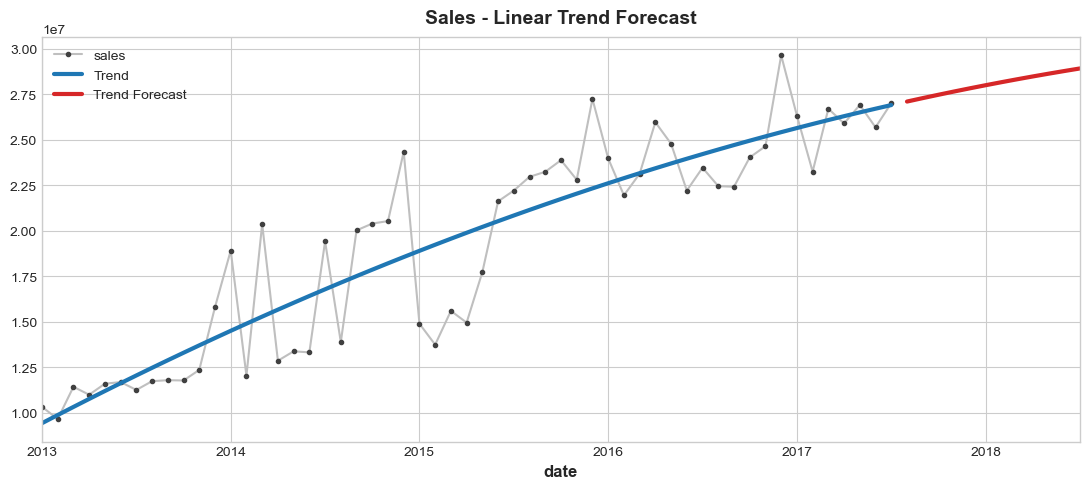

In [42]:
ax = train.plot(title="Sales - Linear Trend Forecast", **plot_params)
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
plt.legend()

# Seasonality

### Seasonal plot code

In [43]:
# Seasonal plot
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

### Periodogram code

In [44]:
# Periodogram
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

### Regression example

<AxesSubplot:title={'center':'Seasonal Plot (year/month)'}, xlabel='month', ylabel='sales'>

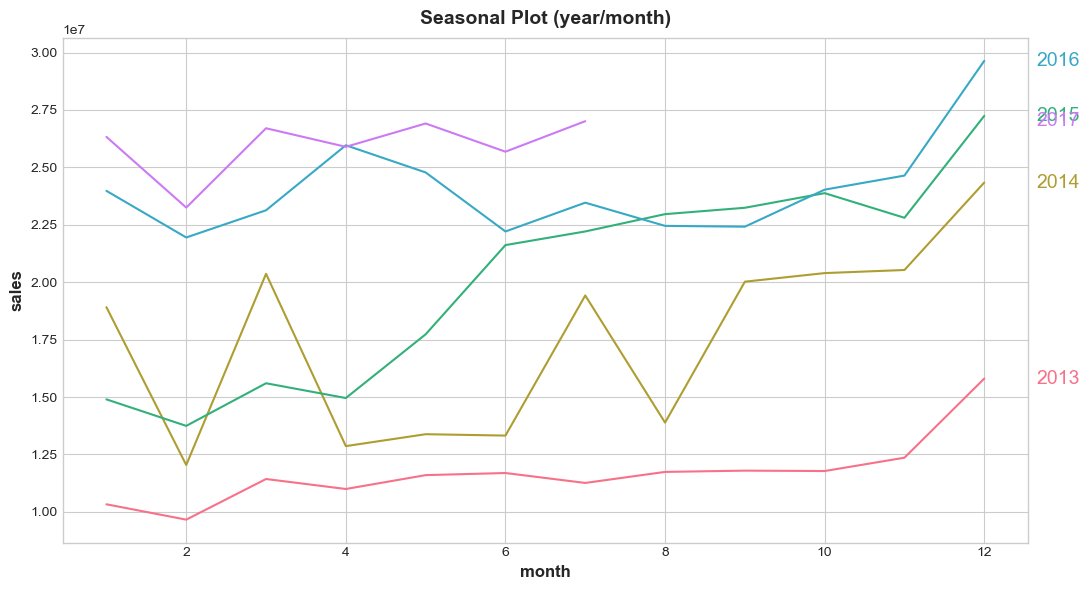

In [45]:
X = data.copy()

X['month'] = X.index.month
X['year'] = X.index.year

fig, ax = plt.subplots(1, 1, figsize=(11, 6))
seasonal_plot(X, y='sales', period='year', freq='month', ax=ax)

C:\Users\RoccoJustice\AppData\Local\Temp\ipykernel_20900\1466452657.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram(data['sales']);


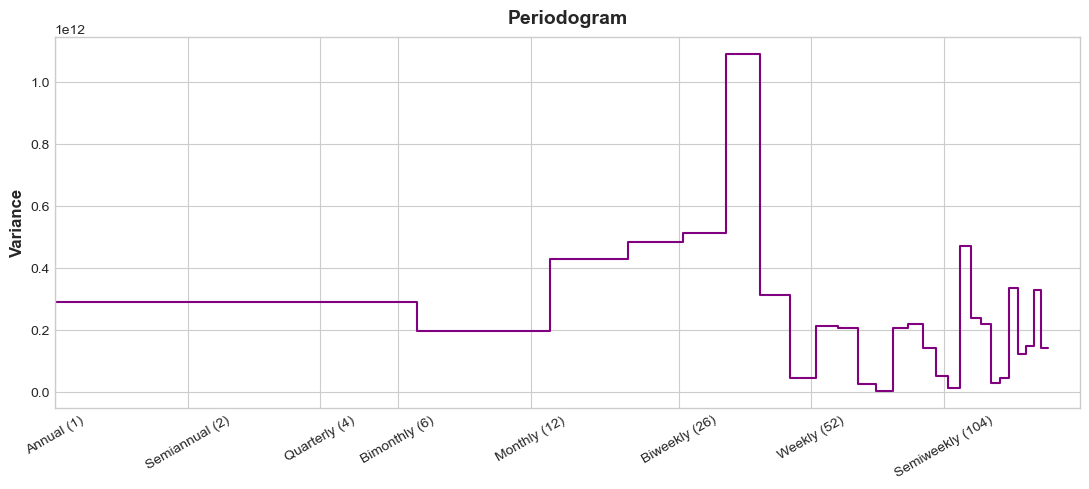

In [46]:
plot_periodogram(data['sales']);

In [47]:
from statsmodels.tsa.deterministic import CalendarFourier

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=data.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

In [48]:
X.tail()

,const,trend,"s(2,12)","s(3,12)","s(12,12)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2017-03-31,1.0,51.0,0.0,1.0,0.0,0.999250,0.038722,0.077386,-0.997001,-0.993257,...,0.230306,-0.973118,-0.963471,-0.267814,-0.304921,0.952378,0.939856,0.341571,0.377708,-0.925925
2017-04-30,1.0,52.0,0.0,0.0,0.0,0.888057,-0.459733,-0.816538,-0.577292,-0.137279,...,-0.271958,0.962309,0.979614,-0.200891,-0.628763,-0.777597,-0.401488,0.915864,0.997917,-0.064508
2017-05-31,1.0,53.0,0.0,0.0,0.0,0.530730,-0.847541,-0.899631,0.436651,0.994218,...,0.213521,-0.976938,-0.699458,0.714673,0.972118,-0.234491,-0.948362,-0.317191,0.635432,0.772157
2017-06-30,1.0,54.0,0.0,0.0,0.0,0.043022,-0.999074,-0.085965,0.996298,0.128748,...,-0.255353,0.966848,0.296713,-0.954967,-0.337523,0.941317,0.377708,-0.925925,-0.417194,0.908818
2017-07-31,1.0,55.0,0.0,0.0,0.0,-0.471160,-0.882048,0.831171,0.556017,-0.995105,...,0.196673,-0.980469,0.288482,0.957485,-0.705584,-0.708627,0.956235,0.292600,-0.981306,0.192452


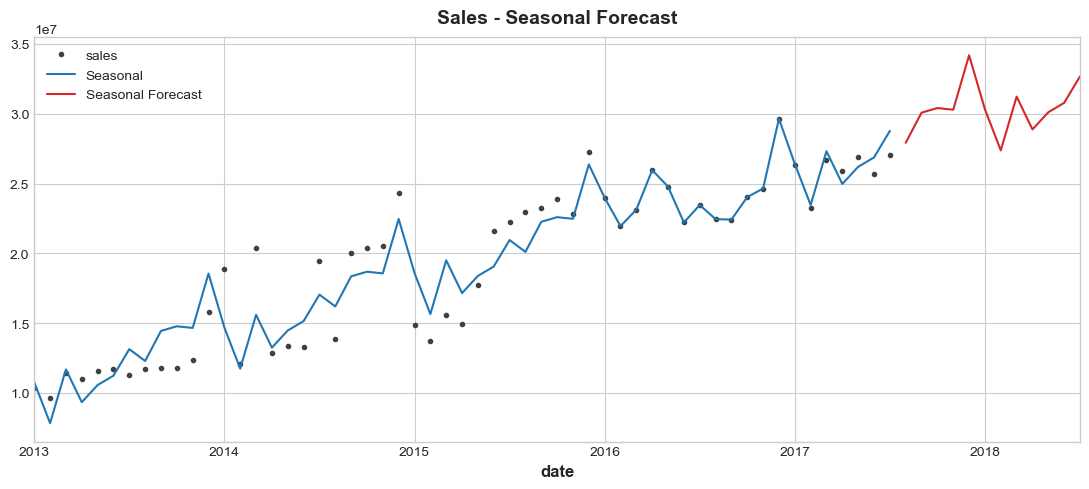

In [49]:
y = data['sales']

model = LinearRegression(fit_intercept=False)
results = model.fit(X, y)

y_pred = pd.Series(results.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=12)
y_fore = pd.Series(results.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Sales - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
ax.legend();

### Regression

In [50]:
store_sales = pd.read_csv('train.csv', usecols=['date', 'sales'], parse_dates=['date'], infer_datetime_format=True, index_col='date')

"\nstore_sales['date'] = store_sales.date.dt.to_period('D')\n\nstore_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()\n\naverage_sales = (\n    store_sales\n    .groupby('date').mean()\n    .squeeze()\n    .loc['2017']\n)\n"

In [51]:
average_sales = store_sales.resample('D').mean().loc['2017']

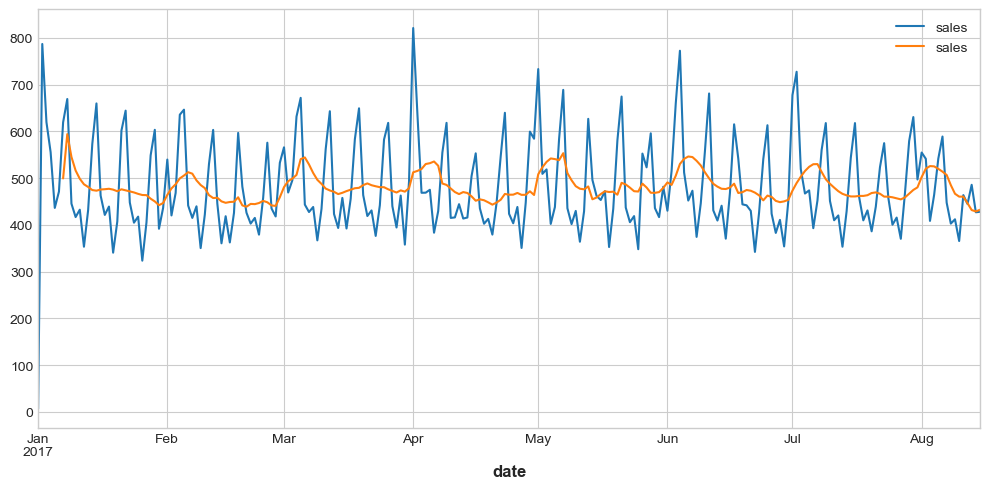

In [52]:
fig, ax = plt.subplots(figsize=(10, 5))
average_sales.plot(label='sales', ax=ax)
average_sales.rolling(window=7).mean().plot(label='moving avg', ax=ax)
plt.legend(loc='best');

C:\Users\RoccoJustice\AppData\Local\Temp\ipykernel_20900\4200732906.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  X["week"] = X.index.week


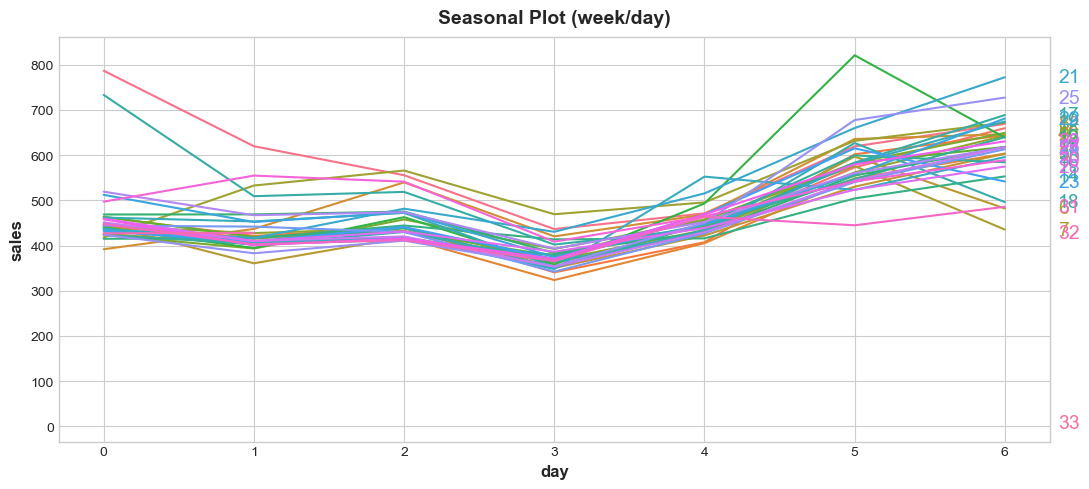

In [53]:
X = average_sales.copy()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

C:\Users\RoccoJustice\AppData\Local\Temp\ipykernel_20900\1099696491.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram(average_sales.squeeze())


<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

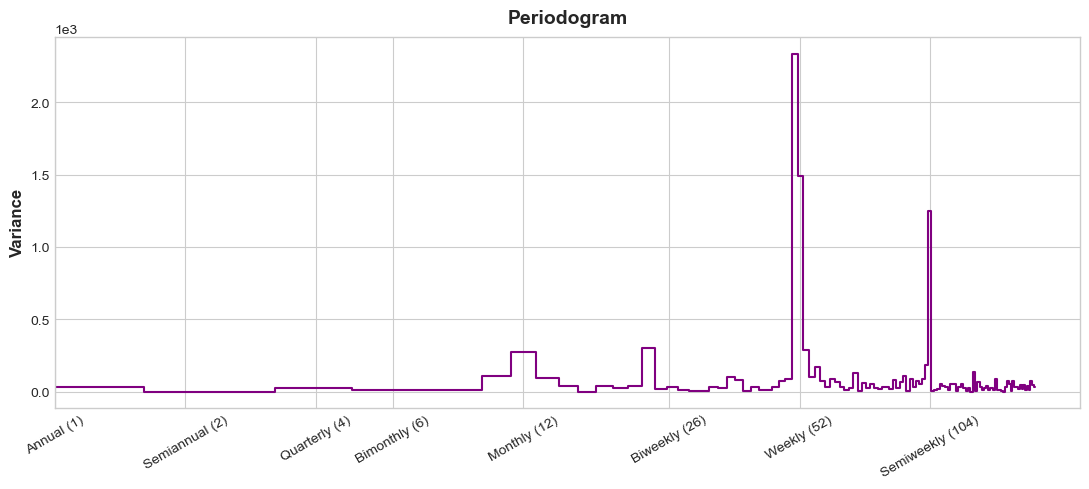

In [54]:
plot_periodogram(average_sales.squeeze())

In [55]:
# For reference, by default Prophet uses a Fourier order of 3 for weekly seasonality, 4 for monthly and 10 for yearly
# https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#:~:text=For%20reference%2C%20by%20default%20Prophet,and%2010%20for%20yearly%20seasonality.
y = average_sales.copy()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)
X = dp.in_sample()

In [56]:
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
date,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869


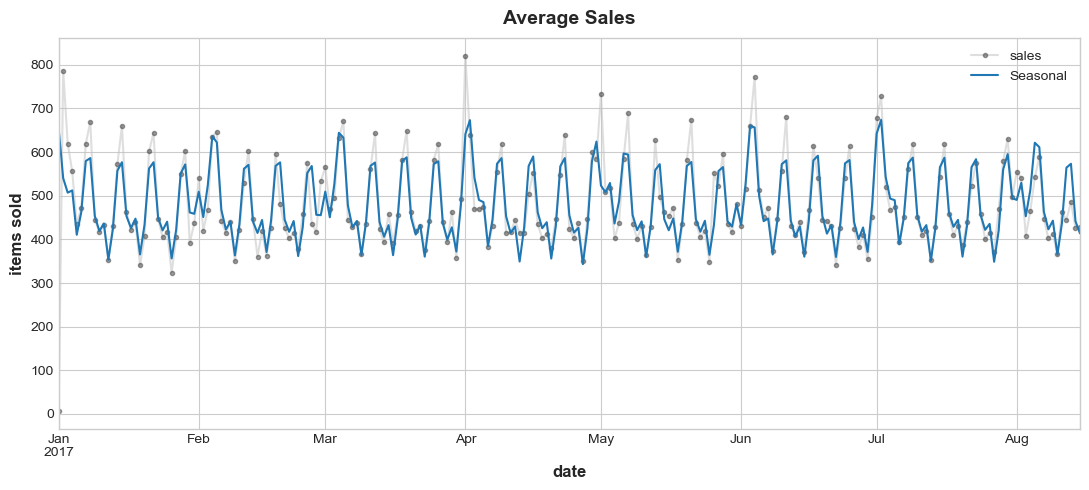

In [57]:
# Modeling and fittign values
model = LinearRegression()
results = model.fit(X, y)

y_pred = pd.Series(results.predict(X).squeeze(), index=X.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend(loc='best')
plt.show();

C:\Users\RoccoJustice\AppData\Local\Temp\ipykernel_20900\1366174271.py:5: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  ax1 = plot_periodogram(y.squeeze(), ax=ax1)
C:\Users\RoccoJustice\AppData\Local\Temp\ipykernel_20900\1366174271.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  ax2 = plot_periodogram(y_deseason, ax=ax2);


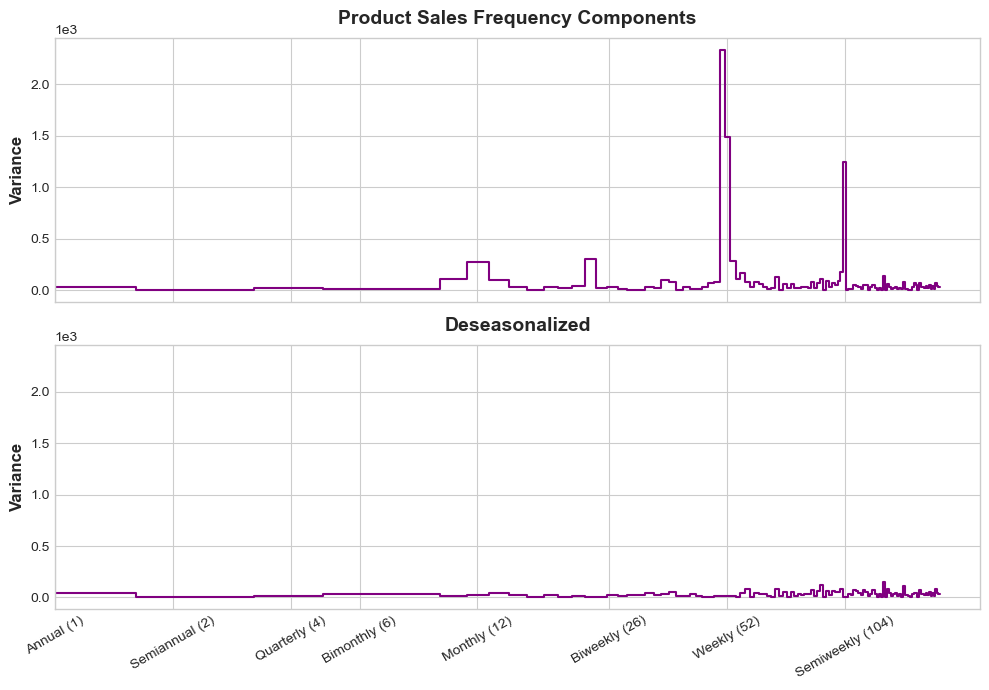

In [58]:
# Checking if model captures seasonality
y_deseason = y.squeeze() - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y.squeeze(), ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

In [59]:
# Include holidays features to capture some noise
holidays_events = pd.read_csv(
    'holidays_events.csv',
    usecols=['date', 'description', 'locale'],
    dtype={
        'locale': 'category',
        'description': 'category',
    },
    parse_dates=['date'],
    infer_datetime_format=True
)


holidays_events = holidays_events.set_index('date')

In [60]:
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017-01-01':'2017-08-18', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

holidays

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


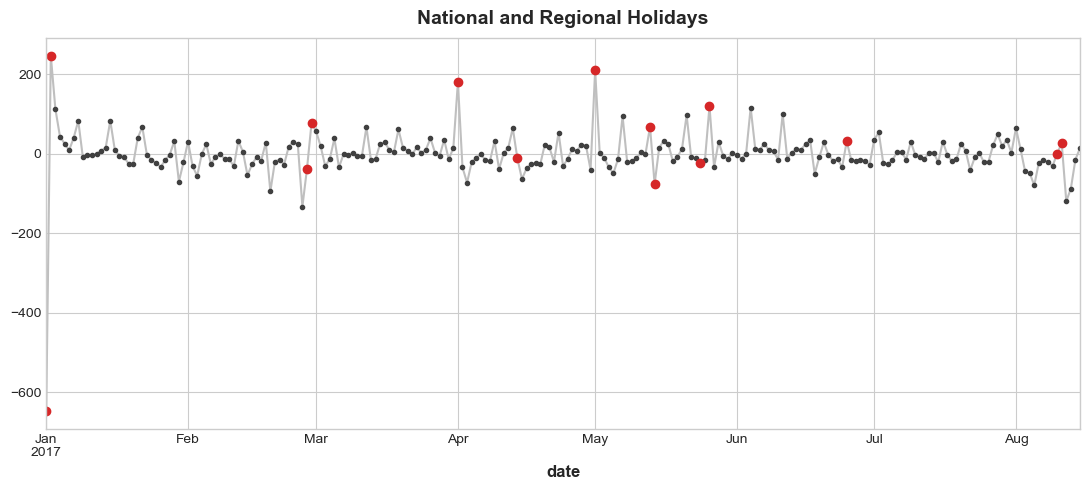

In [61]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index.strftime('%Y-%m-%d').to_list()], color='C3')
ax.set_title('National and Regional Holidays');

In [62]:
X_holidays = pd.get_dummies(holidays)

X2 = X.join(X_holidays, on='date').fillna(0.0)

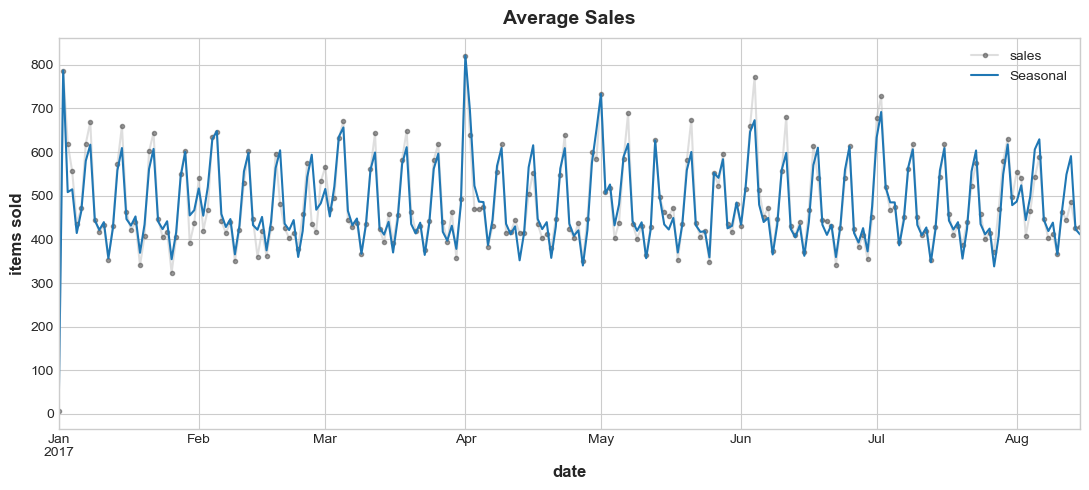

In [63]:
# Fitting and plotting new model
model = LinearRegression()
results = model.fit(X2, y)

y_pred = pd.Series(model.predict(X2).reshape(-1), index=X2.index, name='Fitted')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

In [64]:
store_sales = raw.reset_index().set_index(['store_nbr', 'family', 'date']).sort_index()

In [65]:
y_train = store_sales.unstack(['store_nbr', 'family']).loc['2017']

# Create training data
fourier = CalendarFourier(freq='M', order=3)
dp = DeterministicProcess(
    index=y_train.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
results = model.fit(X, y_train)
y_pred = pd.DataFrame(results.predict(X), index=X.index, columns=y_train.columns)

In [66]:
store_sales.index.get_level_values('family').unique()

CategoricalIndex(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
                  'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI',
                  'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II',
                  'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
                  'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR',
                  'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER',
                  'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES',
                  'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
                  'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
                 categories=['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', ...], ordered=False, dtype='category', name='family')

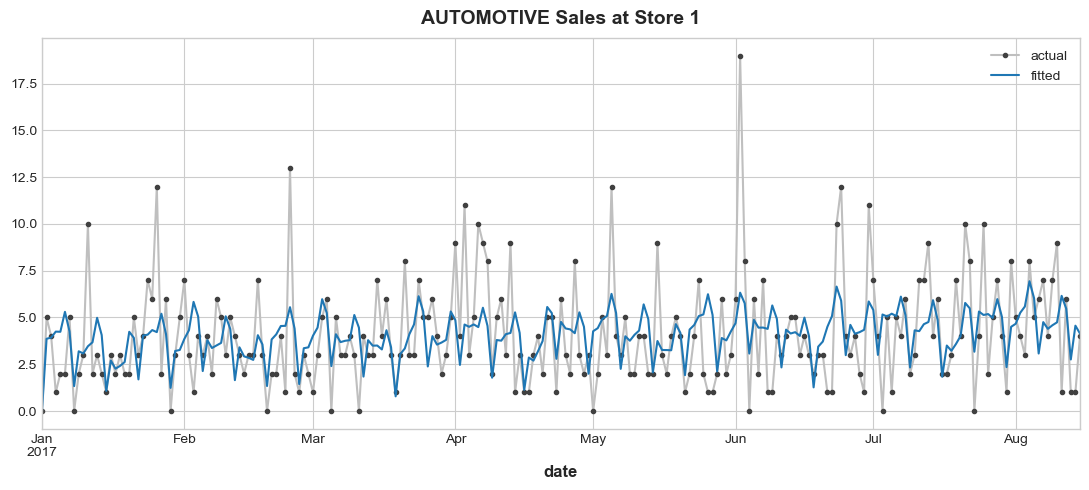

In [71]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'AUTOMOTIVE'

ax = y_train.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params, label='actual')
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax, label='fitted')
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}')
plt.legend(loc='best');

In [74]:
from sklearn.metrics import mean_squared_error as MSE

mse = MSE(y_train, y_pred)
mse

60722.900627046976

In [ ]:
'''
for i in top5_storenbr:
    for j in top5_families:
        plt.figure()
        ax = y.loc(axis=1)['sales', i, j].plot(**plot_params, label='actual')
        ax = y_pred.loc(axis=1)['sales', i, j].plot(ax=ax, label='fitted')
        ax.set_title(f'{j} Sales at Store {i}')
        plt.legend(loc='best');
'''        

"\nfor i in top5_storenbr:\n    for j in top5_families:\n        plt.figure()\n        ax = y.loc(axis=1)['sales', i, j].plot(**plot_params, label='actual')\n        ax = y_pred.loc(axis=1)['sales', i, j].plot(ax=ax, label='fitted')\n        ax.set_title(f'{j} Sales at Store {i}')\n        plt.legend(loc='best');\n"

In [75]:
test = pd.read_csv(
    'test.csv',
    usecols=['store_nbr', 'family', 'date'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32'
    },
    parse_dates=['date'],
    infer_datetime_format=True,
    index_col=['store_nbr','family','date']
)

In [76]:
test['sales'] = 0

In [78]:
y_test = test.unstack(['store_nbr','family'])

fourier = CalendarFourier(freq='M', order=3)
dp = DeterministicProcess(
    index=y_test.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.day_of_year == 1)

forecast = pd.DataFrame(results.predict(X), index=X.index, columns=y_test.columns)

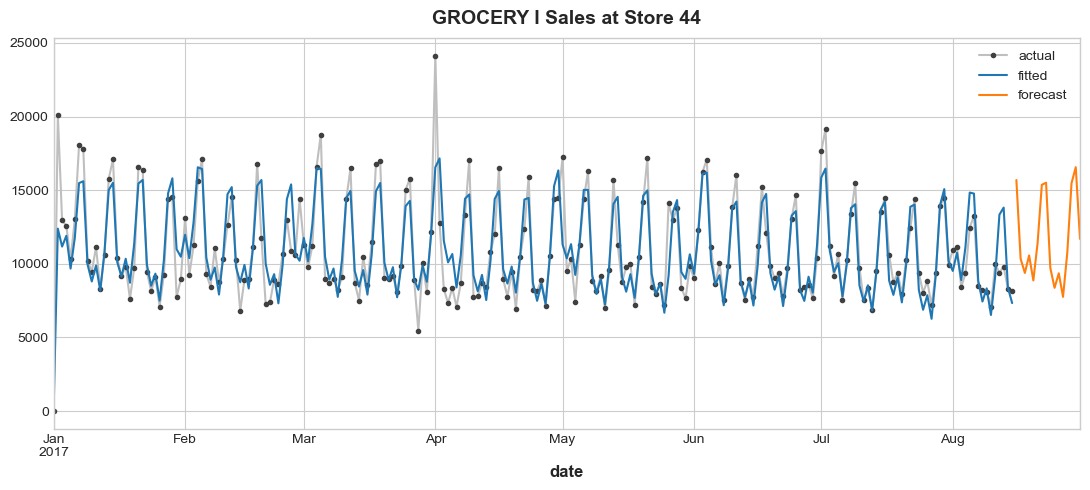

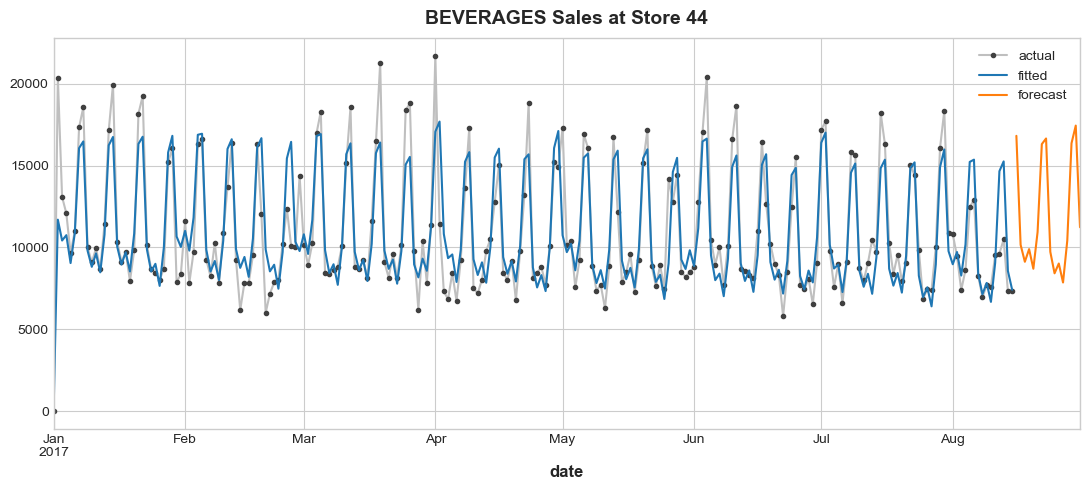

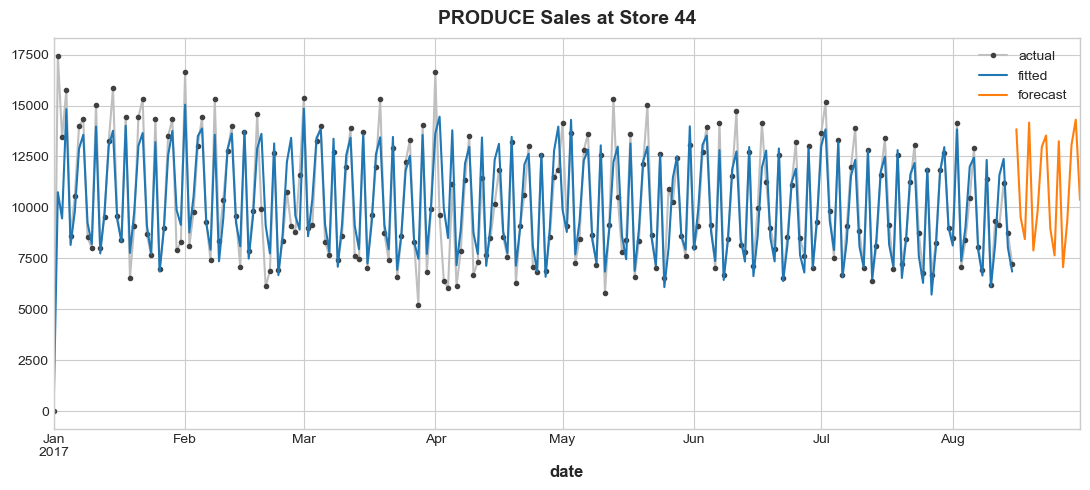

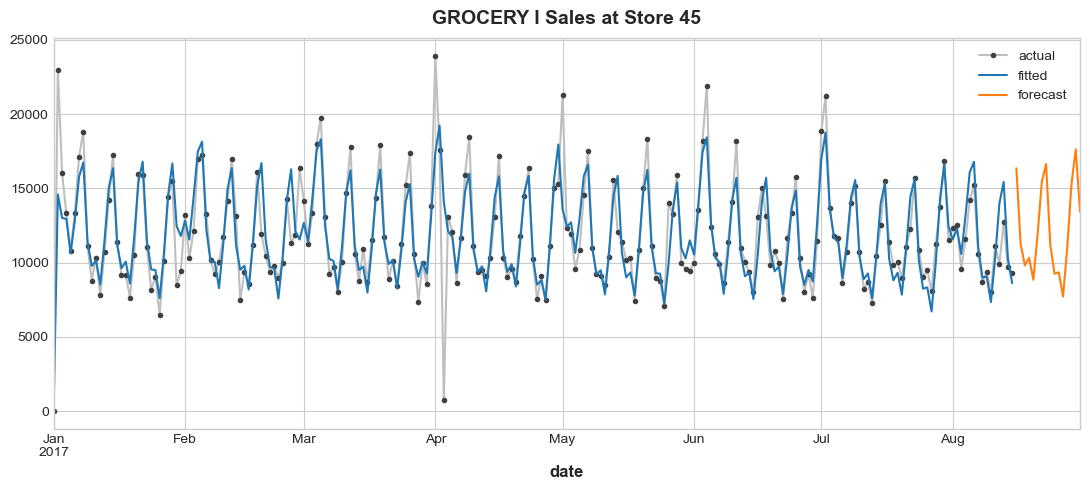

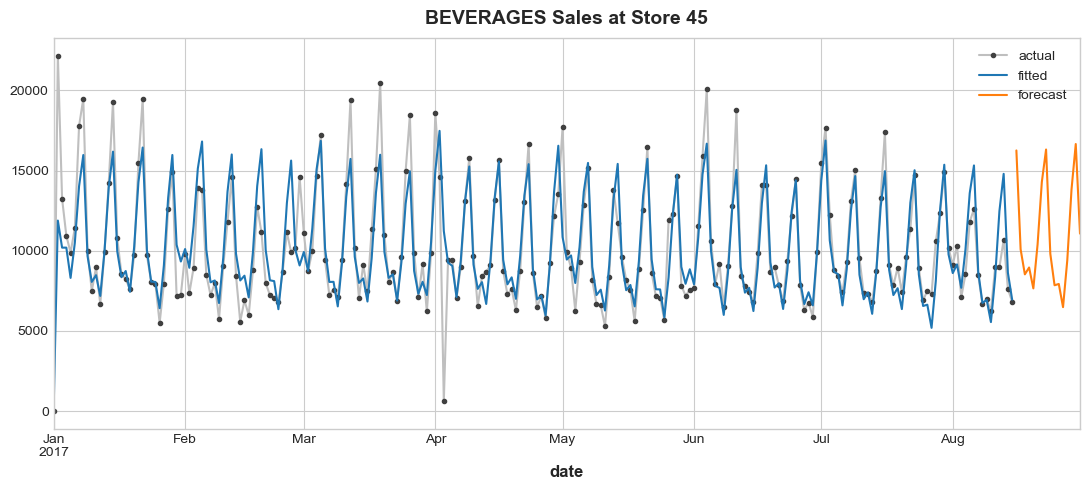

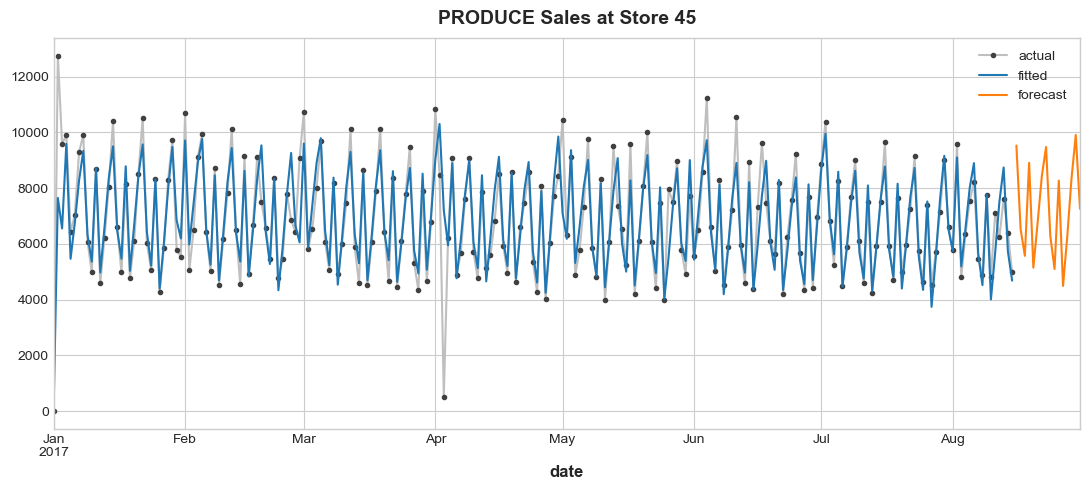

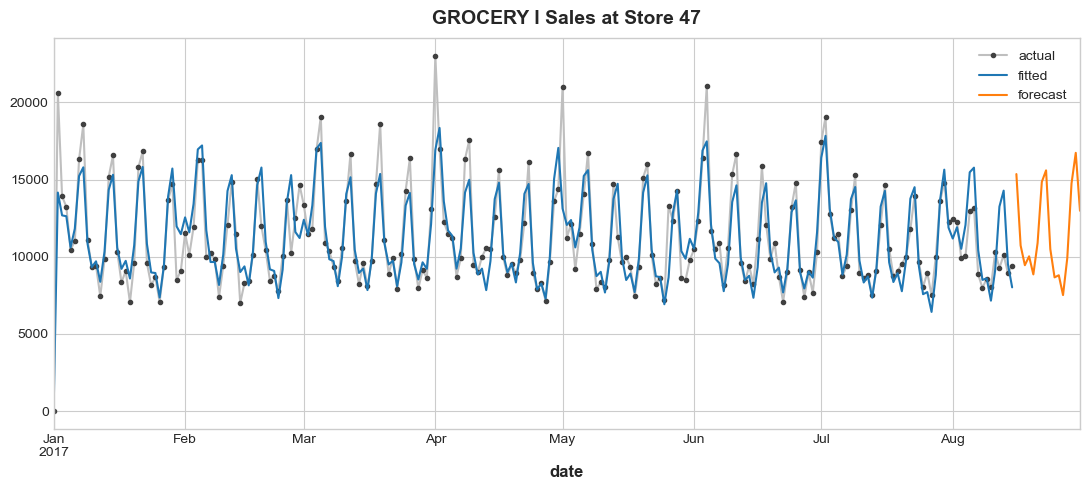

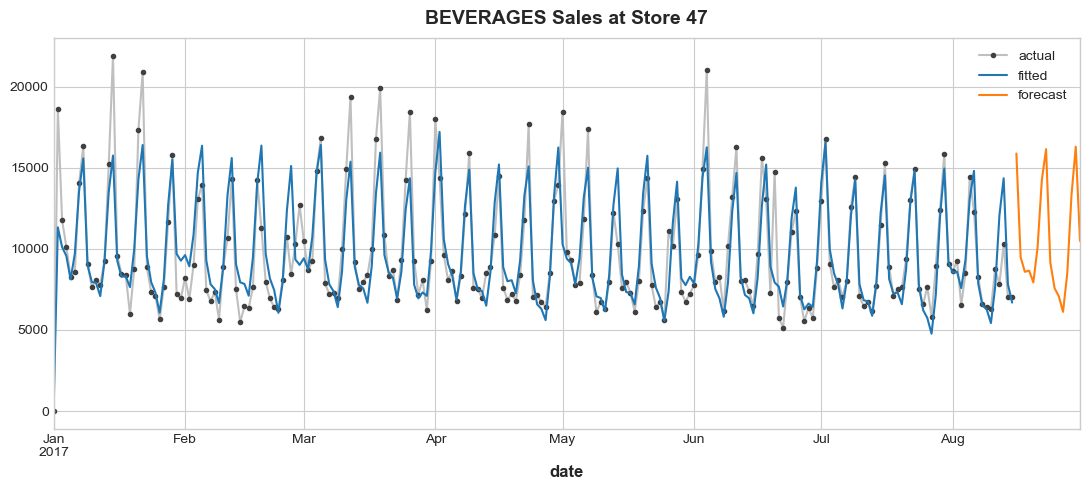

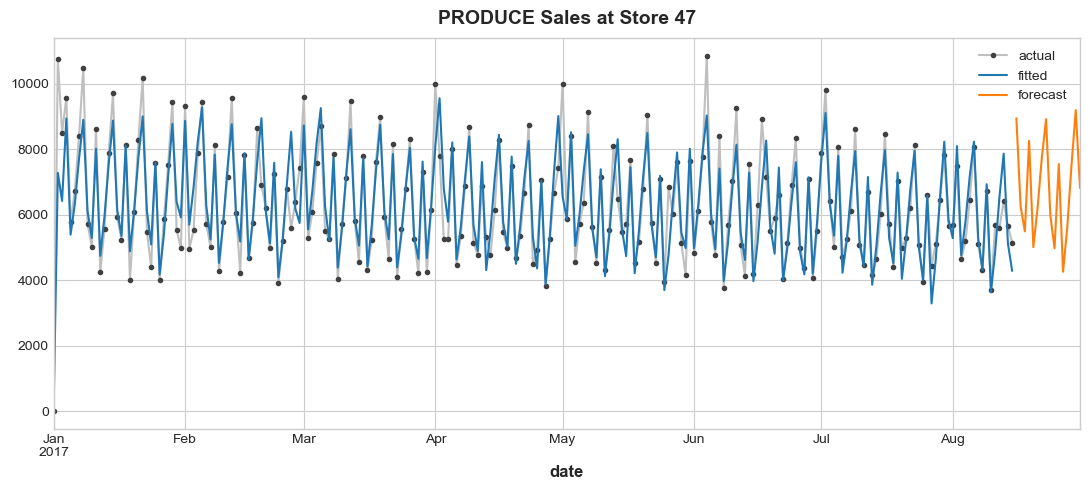

In [81]:
for i in top5_storenbr[0:3]:
    for j in top5_families[0:3]:
        try:
            plt.figure()
            ax = y_train.loc(axis=1)['sales', i, j].plot(**plot_params, label='actual')
            ax = y_pred.loc(axis=1)['sales', i, j].plot(ax=ax, label='fitted')
            ax = forecast.loc(axis=1)['sales', i, j].plot(ax=ax, label='forecast')
            ax.set_title(f'{j} Sales at Store {i}')
            plt.legend(loc='best');
        
        except:
            continue